# Setup enviroment

In [2]:
!pip3 install hiddenlayer > /dev/null
!pip3 install ipdb > /dev/null
import json
import os
import numpy as np
import random
import time

import torch as tr
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision.datasets.folder import default_loader
from torchvision.transforms import functional as ft
from torchvision import transforms
from PIL import Image, ImageDraw

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import balanced_accuracy_score

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import hiddenlayer as hl

from google.colab import drive

from tqdm.notebook import tqdm

IMG_SIZE = (512, 384)

tr.backends.cudnn.deterministic = False
tr.backends.cudnn.benchmark = True

In [3]:
drive.mount('./drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at ./drive


In [4]:
os.chdir("/content/drive/My Drive/Workspace/pic2sgf/train")

# Dataset

In [5]:
class BoardExtractor():
    def __init__(self, size):
        self.size = size
        B = np.array([[8, 8, 1],
                      [self.size-8, 8, 1],
                      [self.size-8, self.size-8, 1],
                      [8, self.size-8, 1]]).T
        self.T2 = np.linalg.inv(B[:, 0:3] * np.linalg.solve(B[:, 0:3], B[:, 3]))

    def __call__(self, img, vertexs):
        A = np.concatenate([vertexs.T, np.array([[1.0, 1.0, 1.0, 1.0]])], axis=0)
        T1 = A[:, 0:3] * np.linalg.solve(A[:, 0:3], A[:, 3])
        T = np.matmul(T1, self.T2)
        T /= T[2,2]
        board = img.transform((self.size, self.size),
                              method=Image.PERSPECTIVE,
                              data = T.reshape(-1),
                              resample=Image.BILINEAR)
        return board.transpose(Image.ROTATE_180)

In [37]:
class BoardSizeDataset(Dataset):
    def __init__(self, metadata_file):
        super(BoardSizeDataset, self).__init__()
        self.classes = [9, 13, 19]
        with open(metadata_file, 'r') as f:
            metadata = json.load(f)
        self.board_extractor = BoardExtractor(192)
        self.size = []
        self.vertexs = []
        self.image = []
        for entry in tqdm(metadata):
            self.size.append(entry['size'])
            vertexs = np.array(entry['corners'])/100
            vertexs[:, 0] *= IMG_SIZE[0]
            vertexs[:, 1] *= IMG_SIZE[1]
            self.vertexs.append(vertexs)
            self.image.append(default_loader("images/" + entry['filename']).resize(IMG_SIZE, resample=Image.BILINEAR))

    def __getitem__(self, i):
        vertexs = self.vertexs[i] + np.random.normal(scale=1, size=(4,2))
        if np.random.binomial(1, 0.1):
            lbl = 3
            vertexs[np.random.randint(0, 4)] += np.random.randint(12, 100, size=2) * (2*np.random.binomial([0,1], 0.5)-1)
        else:
            lbl = self.classes.index(self.size[i])
        
        img = self.board_extractor(self.image[i], vertexs)
        img = ft.adjust_brightness(img, np.clip(np.random.normal(loc=1, scale=0.3), 0.4, 1.6))
        img = ft.adjust_contrast(img, np.clip(np.random.normal(loc=1, scale=0.3), 0.4, 1.6))
        img = ft.adjust_gamma(img, np.clip(np.random.normal(loc=1, scale=0.3), 0.4, 1.6))
        img = ft.adjust_saturation(img, np.clip(np.random.normal(loc=1, scale=0.3), 0.4, 1.6))
        if np.random.binomial(1, 0.5): img = ft.hflip(img)
        img = ft.to_tensor(img)
        return img.mean(0, keepdim=True), lbl

    def __len__(self):
      return len(self.image)

dataset = BoardSizeDataset('metadata.json')
len(dataset)

344

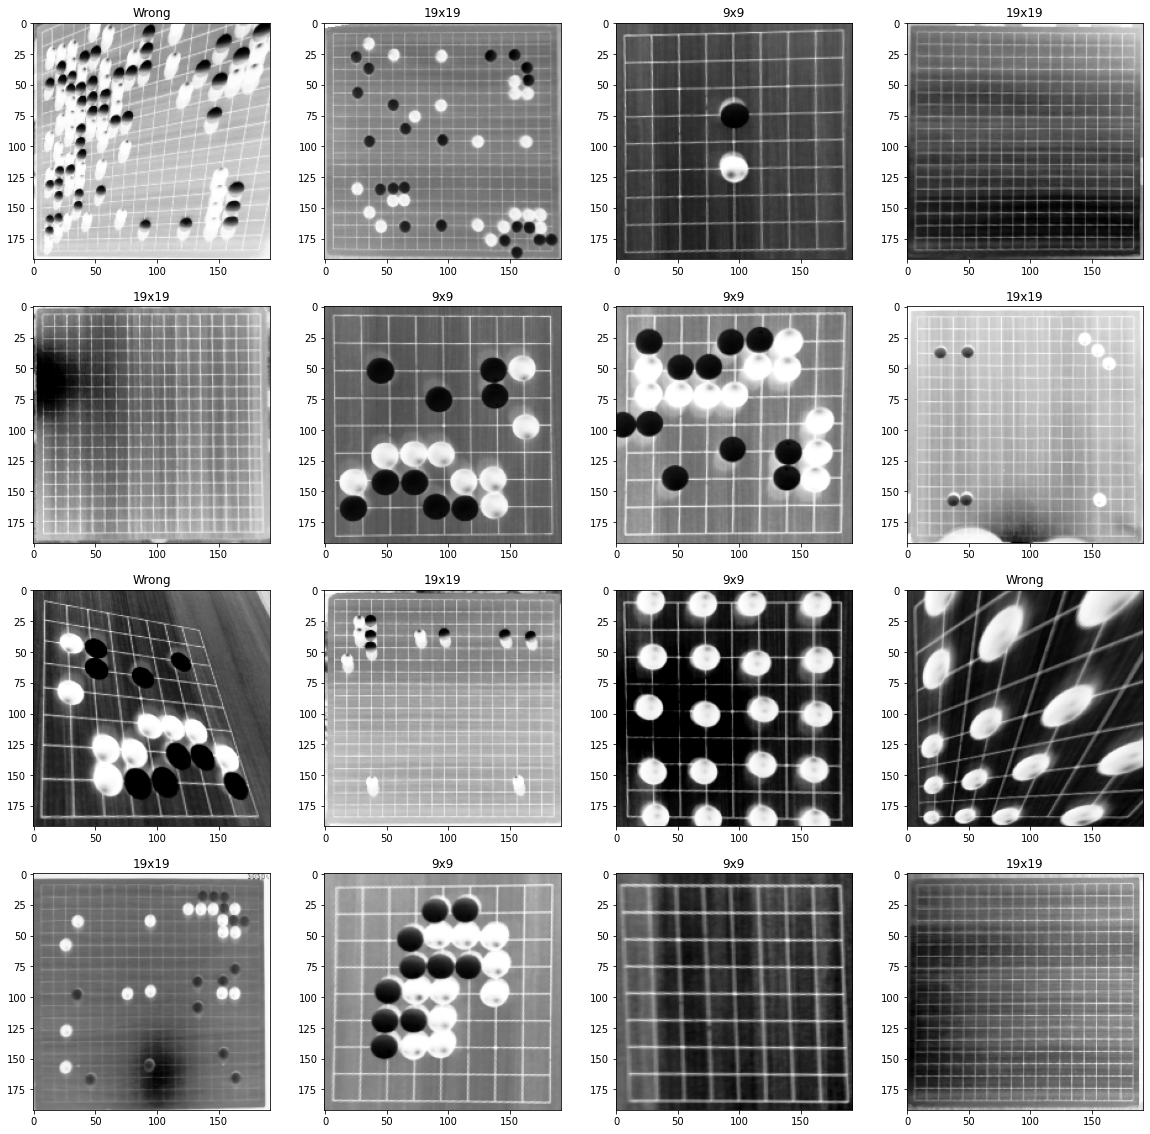

In [38]:
plt.figure(figsize=(20,20))
for i in range(16):
    plt.subplot(4, 4, i+1)
    index = random.randrange(len(dataset))
    img, lbl = dataset[index]
    plt.imshow(img.squeeze(), cmap="Greys")
    if lbl < 3:
        size = [9, 16, 19][lbl]
        plt.title(f'{size}x{size}')
    else:
        plt.title('Wrong')
plt.show()

# Model

In [63]:
class iblock(nn.Module):
    def __init__(self, dims):
        super(iblock, self).__init__()
        self.conv_path = nn.Sequential(nn.BatchNorm2d(dims), nn.GELU(),
                                       nn.Conv2d(dims, dims, kernel_size=3, padding=1),
                                       nn.GELU(), nn.BatchNorm2d(dims),
                                       nn.Conv2d(dims, dims, kernel_size=3, padding=1))
        
    def forward(self, x):
        return x + self.conv_path(x)


class Sizer(nn.Module):
    def __init__(self):
        super(Sizer, self).__init__()
        self.conv_blocks = nn.Sequential(nn.Conv2d(1, 8, kernel_size=3, stride=3), # 64
                                         iblock(8), nn.GELU(), nn.BatchNorm2d(8),
                                         nn.Conv2d(8, 16, kernel_size=2, stride=2), # 32
                                         iblock(16), nn.GELU(), nn.BatchNorm2d(16),
                                         nn.Conv2d(16, 32, kernel_size=2, stride=2), # 16
                                         iblock(32), nn.GELU(), nn.BatchNorm2d(32),
                                         nn.Conv2d(32, 64, kernel_size=2, stride=2), # 8
                                         iblock(64), nn.GELU(), nn.BatchNorm2d(64),
                                         nn.AdaptiveAvgPool2d(1))
        
        self.linear = nn.Sequential(nn.Linear(64, 16), nn.GELU(), nn.BatchNorm1d(16),
                                    nn.Dropout(0.2), nn.Linear(16, 4), nn.Sigmoid())
                                         

    def forward(self, x):
        x = self.conv_blocks(x)
        x = self.linear(x.squeeze(3).squeeze(2))
        return x
      
    def load(self, fname):
        self.load_state_dict(tr.load(fname, map_location=lambda storage, loc: storage))

    def save(self, fname):
        tr.save(self.state_dict(), fname)

# Training

In [44]:
model = Sizer().cuda()
hist = hl.History()
canvas = hl.Canvas()

tr.manual_seed(42)
np.random.seed(42)
train, test = random_split(dataset, (len(dataset)-32, 32))

filename = 'sizer_5'

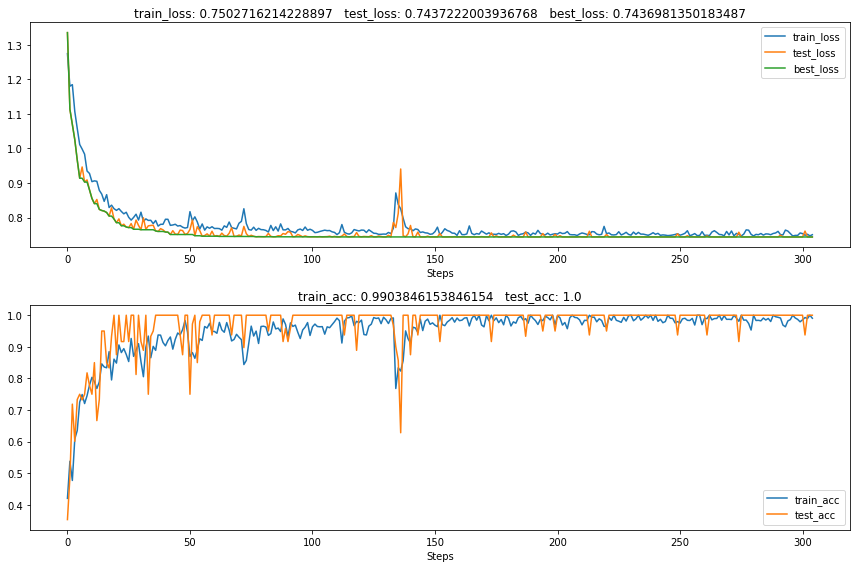

Last Step: 304
Training Time: 0:17:52.721284


In [45]:
if os.path.isfile('models/' + filename + '.pmt'):
    model.load("models/" + fname + ".pmt")
    hist.load("models/" + fname + ".hist")
    epoch = len(hist['best_total'].data)
    best_loss = min(hist['best_loss'].data)
    best_acc = min(hist['best_acc'].data)
else:
    epoch = len(hist['train_loss'].data)
    best_loss = float('inf')
    best_acc = 0

optimizer = tr.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = tr.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=20, min_lr=1e-9)

train_loader = DataLoader(train, batch_size=8, shuffle=True)
test_loader = DataLoader(test, batch_size=8, shuffle=True)

class_weight = np.bincount(np.array(dataset.size))
class_weight = len(dataset) / class_weight[class_weight > 0]
class_weight = np.concatenate([class_weight, np.array([1])])
class_weight /= class_weight.sum()

loss_func = nn.CrossEntropyLoss(weight=tr.Tensor(class_weight).cuda())
        
epochs_without_improvement = 0
while epochs_without_improvement < 100:
    model.train()
    train_loss = 0
    train_acc = 0
    all_preds = []
    all_label = []
    for img, lbl in train_loader:
        img, lbl = img.cuda(), lbl.cuda()
        pred = model(img)
        optimizer.zero_grad()
        loss = loss_func(pred, lbl)
        loss.backward()
        optimizer.step()
        train_loss += loss.data.item() / len(train_loader)
        all_preds.append(pred.detach().cpu().numpy().argmax(1))
        all_label.append(lbl.detach().cpu().numpy())
    train_acc = balanced_accuracy_score(np.concatenate(all_label), np.concatenate(all_preds))

    model.eval()
    test_loss = 0
    test_acc = 0
    all_preds = []
    all_label = []
    for img, lbl in test_loader:
        img, lbl = img.cuda(), lbl.cuda()
        pred = model(img)
        loss = loss_func(pred, lbl)
        test_loss += loss.data.item() / len(test_loader)
        all_preds.append(pred.detach().cpu().numpy().argmax(1))
        all_label.append(lbl.detach().cpu().numpy())
    test_acc = balanced_accuracy_score(np.concatenate(all_label), np.concatenate(all_preds))
    scheduler.step(test_loss)

    if test_loss <= best_loss:
        model.save('models/' + filename + ".pmt")
        hist.save('models/' + filename + ".hist")
        best_loss = test_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    hist.log(epoch, train_loss=train_loss,
                    test_loss=test_loss,
                    best_loss=best_loss,
                    test_acc=test_acc,
                    train_acc=train_acc)

    with canvas:
        canvas.draw_plot([hist["train_loss"],
                          hist["test_loss"],
                          hist["best_loss"]])
        canvas.draw_plot([hist["train_acc"],
                          hist["test_acc"]])
    epoch += 1

hist.summary()

In [46]:
16*19

304

# Test

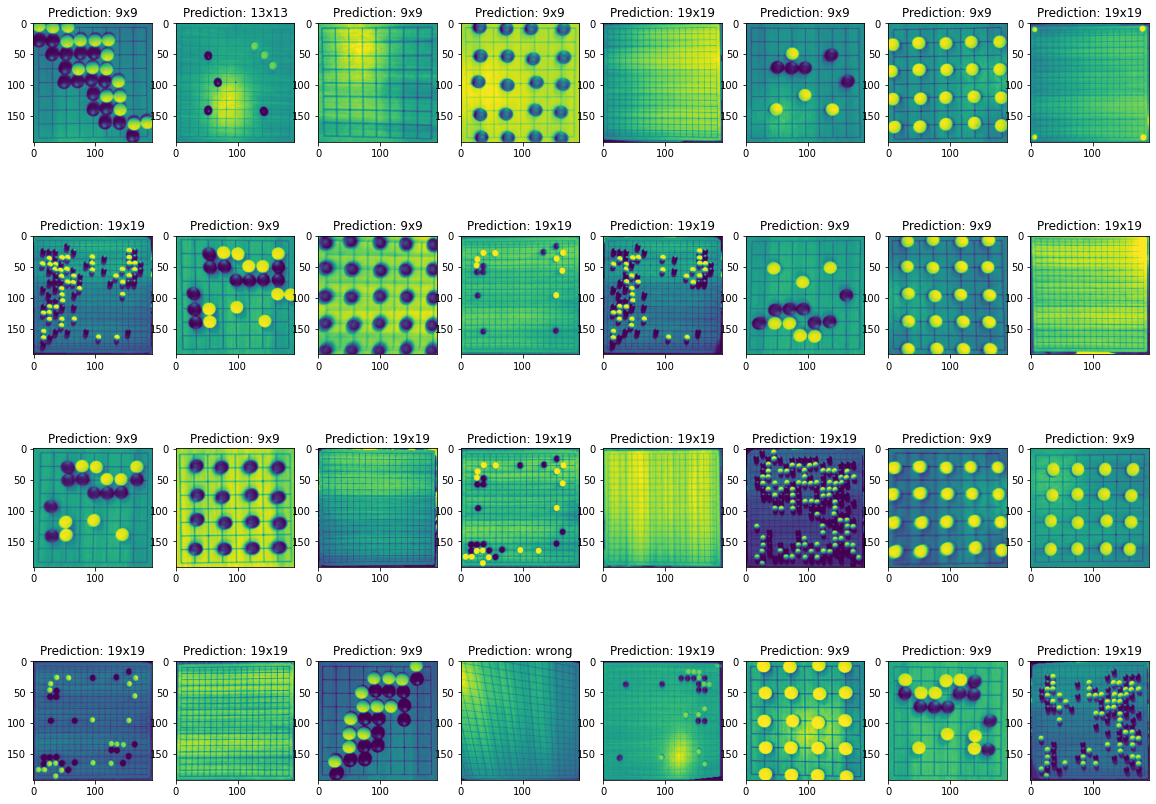

In [69]:
plt.figure(figsize=(20, 15))
class_name = ["9x9", "13x13", "19x19", "wrong"]

model = Sizer()
model.load('models/' + filename + ".pmt")
model.eval()

for i in range(len(test)):
    plt.subplot(4, 8, i+1)
    img, lbl = test[i]
    x = img.unsqueeze(0)
    pred = model(x).detach().argmax(1)
    pred = class_name[pred]
    plt.imshow(img.squeeze())
    plt.title(f'Prediction: {pred}')
plt.show()